In [1]:
# Data analysis packages
import pandas as pd
import numpy as np
import re

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# NLP packages
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk.classify.util
from textblob import Word, TextBlob

# Scaling
from sklearn.preprocessing import scale

In [2]:
#****************************************************
# Data Import
#****************************************************

data = pd.read_csv('googleplaystore.csv', 
                    parse_dates=['Last Updated'])

data_reviews = pd.read_csv('googleplaystore_user_reviews.csv')

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data_reviews.dropna(inplace=True)
data_reviews.reset_index(drop=True, inplace=True)

In [3]:
#****************************************************
# Data Cleaning
#****************************************************

# Cleaning installs column
install = np.array(data.Installs)

for i in range(len(install)):
    install[i] = install[i].strip('+')
    install[i] = int(install[i].replace(',', ''))

data.Installs = install

# Cleaning last update column
dates = pd.DatetimeIndex(data['Last Updated'])
data['Last Updated'] = dates.year

# Removing columns which are not required 
del(data['Current Ver'])
del(data['Android Ver'])
del(data['Genres'])

In [4]:
#**********************************************
# Exploratory Data Analysis
#**********************************************

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9359 entries, 0 to 9358
Data columns (total 10 columns):
App               9359 non-null object
Category          9359 non-null object
Rating            9359 non-null float64
Reviews           9359 non-null object
Size              9359 non-null object
Installs          9359 non-null object
Type              9359 non-null object
Price             9359 non-null object
Content Rating    9359 non-null object
Last Updated      9359 non-null int64
dtypes: float64(1), int64(1), object(8)
memory usage: 731.2+ KB
None


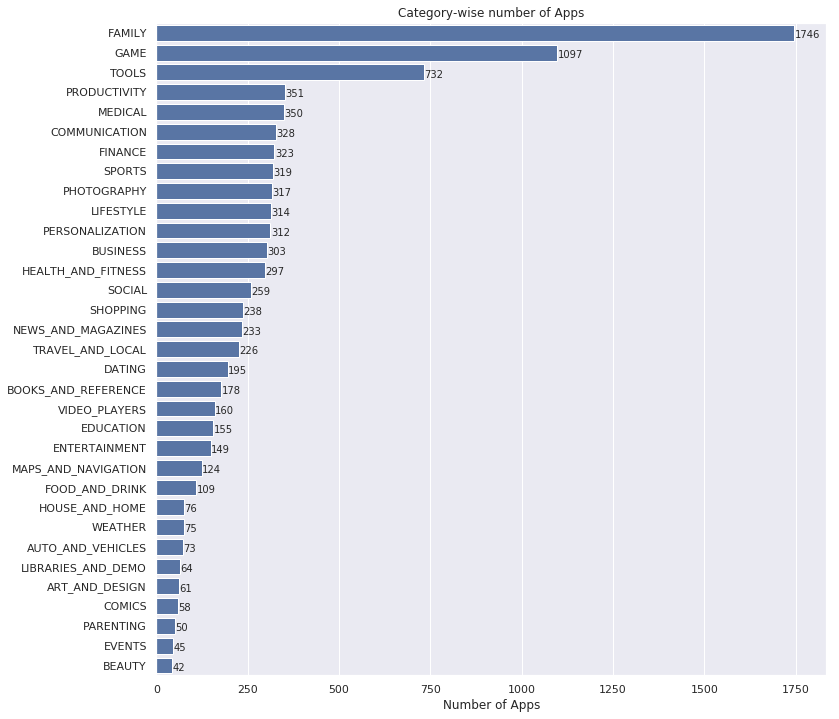

In [5]:
fig = plt.figure(figsize=(12,12))
ax1 = plt.axes()
df2 = data['Category'].value_counts()
df2 = df2.reset_index()
sns.barplot(x = df2['Category'],y = df2['index'],color='b',ax=ax1,orient='h')
plt.xlabel('Number of Apps')
plt.ylabel('')
plt.title('Category-wise number of Apps')
for i, v in enumerate(df2['Category'].values):
    ax1.text(v + 1, i + .25, str(v))
plt.show()

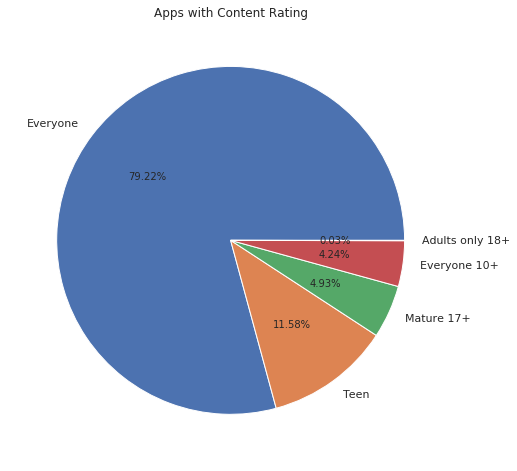

In [6]:
medals=data['Content Rating'].value_counts()
labels=medals.index

fig = plt.figure(figsize=(8,8))
plt.pie(medals,labels=labels,autopct='%1.2f%%',radius=1)
plt.title('Apps with Content Rating')
plt.show()

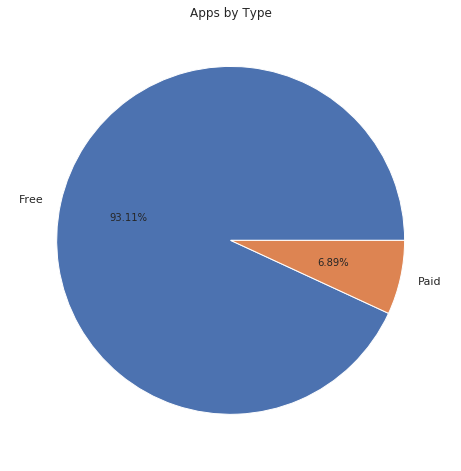

In [7]:
medals=data['Type'].value_counts()
labels=medals.index

fig = plt.figure(figsize=(8,8))
plt.pie(medals,labels=labels,autopct='%1.2f%%',radius=1)
plt.title('Apps by Type')
plt.show()

In [8]:
import plotly.offline as off
import plotly.graph_objs as go
off.init_notebook_mode(connected = True)

cat_eda = data.groupby(['Category']).agg({'Installs':'sum'})
cat_eda.sort_values('Installs', ascending=False, inplace=True)
cat_eda = cat_eda.head(12)
labels = cat_eda.index
values = cat_eda.Installs

common_props = dict(labels=labels,
                    values=values,)

trace1 = go.Pie(
    **common_props,
    textinfo='percent',
    textposition='outside')

trace2 = go.Pie(
    **common_props,
    textinfo='label',
    textposition='inside')

off.iplot([trace1, trace2], filename='basic_pie_chart')

In [10]:
#****************************************************
# Data Processing
#****************************************************

In [6]:
#**** Basic Sentiment analysis of App reviews ****#

a=pd.DataFrame(data_reviews.loc[:,['App', 'Translated_Review']])
a.head()

# lower case
lower = lambda x: " ".join(x.lower() for x in x.split())
a['Processed_review'] = a['Translated_Review'].apply(lower)
a['Processed_review'].head()

# remove punctuations
a['Processed_review'] = a['Processed_review'].str.replace('[^\w\s]','')
a['Processed_review'].head()

# remove stop words
stop = stopwords.words('english')
rem_stop = lambda x: " ".join(x for x in x.split() if x not in stop)
a['Processed_review'] = a['Processed_review'].apply(rem_stop)
a['Processed_review'].head()

#count freq words
freq = pd.Series(' '.join(a['Processed_review']).split())
freq = freq.value_counts()[:10]
freq

# remove words with high frequency 
freq = list(freq.index)
rem_freq = lambda x: " ".join(x for x in x.split() if x not in freq)
a['Processed_review'] = a['Processed_review'].apply(rem_freq)
a['Processed_review'].head()

# count rare words
freq = pd.Series(' '.join(a['Processed_review']).split())
freq = freq.value_counts()[-10:]
freq

# remove words with less frequency
freq = list(freq.index)
rem_freq = lambda x: " ".join(x for x in x.split() if x not in freq)
a['Processed_review'] = a['Processed_review'].apply(rem_freq)
a['Processed_review'].head()

# tokenization
a['tokenized_sentences'] = a['Processed_review'].apply(word_tokenize) 
a.head()

#  Lemmatization
lem = lambda x: " ".join([Word(word).lemmatize() for word in x])
a['Lemmatization'] = a['tokenized_sentences'].apply(lem)
a.head()

# sentiment rating (polarity)
polar = lambda x: TextBlob(x).sentiment[0]
a['Polarity'] = a['Lemmatization'].apply(polar)
a[['Lemmatization','Polarity']].head(10)


pos = [0]*len(a)
neg = [0]*len(a)
neu = [0]*len(a)
x = np.array(a['Polarity'])

for i in range(len(a)):
    if x[i] < 0:
        neg[i] = 1
    elif x[i] == 0:
        neu[i] = 1
    else:
        pos[i] = 1

a['Positive'] = pos
a['Negative'] = neg
a['Neutral'] = neu
a.head()

# Updated dataset with total ratings per app
reviews = a.groupby(['App']).agg({
                        'Positive':'sum',
                        'Negative':'sum',
                        'Neutral':'sum'
                })

In [12]:
#**********************************************
# Merging both datasets
#**********************************************

In [7]:
n_data = pd.merge(data, reviews, how='inner', on='App')
n_data.dropna(inplace=True)
n_data.drop_duplicates(subset='App', keep='first', inplace=True)
n_data.reset_index(drop=True, inplace=True)

In [8]:
# Writing processed data to a new file
filename = 'Processed_data.csv'
n_data.to_csv(path_or_buf=filename, sep=',', mode='w')

In [15]:
#**********************************************
# Loading Processed data
#**********************************************

In [9]:
n_data = pd.read_csv('Processed_data.csv').iloc[:, 1:]

In [10]:
n_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Positive,Negative,Neutral
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,2018,14,12,18
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,1000000,Free,0,Everyone,2017,49,11,30
2,FlipaClip - Cartoon animation,ART_AND_DESIGN,4.3,194216,39M,5000000,Free,0,Everyone,2018,4,0,0
3,Boys Photo Editor - Six Pack & Men's Suit,ART_AND_DESIGN,4.1,654,12M,100000,Free,0,Everyone,2018,11,4,23
4,Colorfit - Drawing & Coloring,ART_AND_DESIGN,4.7,20260,25M,500000,Free,0,Everyone,2017,24,11,3


In [18]:
#**********************************************
# Data Analysis
#**********************************************

In [11]:
# Category-wise data
cat_eda = n_data.groupby(['Category']).agg({
         'Positive':'sum',
         'Neutral':'sum',
         'Negative':'sum',
         'Rating':'mean',
         'Installs':'sum'
})
cat_eda.Rating = cat_eda.Rating.round(1)
cat_eda.Installs = cat_eda.Installs.round()

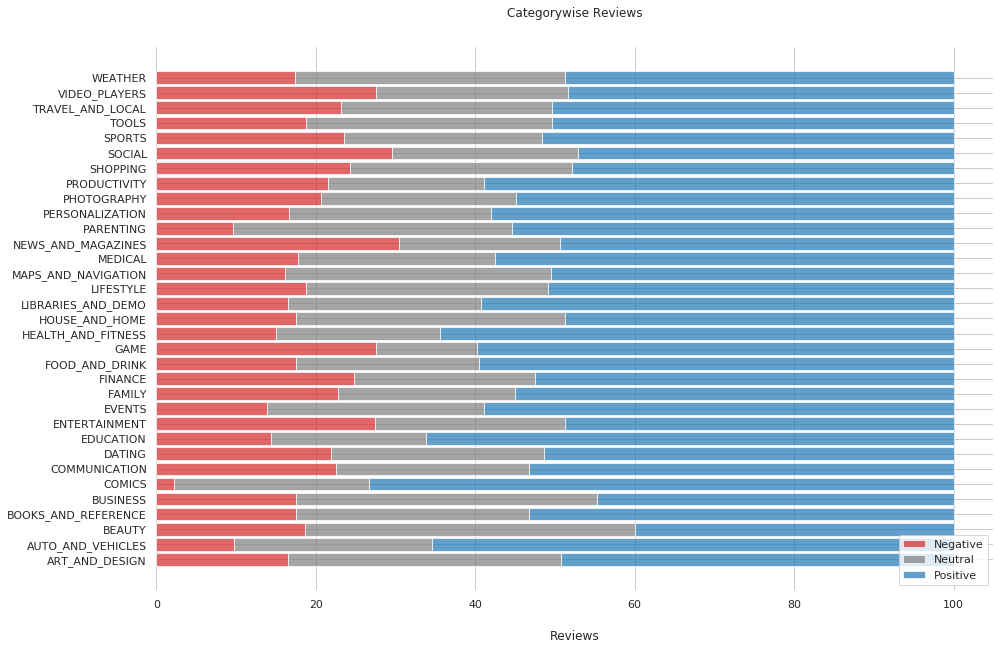

In [12]:
# Plotting percentage of reviews post sentiment analysis
barWidth = 0.85
names = cat_eda.index
col_names = ['Negative','Neutral','Positive']
r = np.arange(len(names))
totals = [i+j+k for i,j,k in zip(cat_eda['Positive'], cat_eda['Neutral'], cat_eda['Negative'])]
posi = [i / j * 100 for i,j in zip(cat_eda['Positive'], totals)]
neut = [i / j * 100 for i,j in zip(cat_eda['Neutral'], totals)]
negi = [i / j * 100 for i,j in zip(cat_eda['Negative'], totals)]

sns.set(style='whitegrid')
plt.figure(figsize=(15, 10))
plt.barh(r, negi, color='tab:red', edgecolor='white', height=barWidth, alpha=0.7)
plt.barh(r, neut, left=negi, color='tab:gray', edgecolor='white', height=barWidth, alpha=0.7)
plt.barh(r, posi, left=[i+j for i,j in zip(negi, neut)], color='tab:blue', edgecolor='white', height=barWidth, alpha=0.7)
plt.yticks(r, names)
plt.xlabel('Reviews', labelpad=20)
plt.title('Categorywise Reviews', pad=30)
plt.legend(col_names, loc=4, frameon=True)
sns.despine(left=True, bottom=True)
plt.show()

In [13]:
# Preparing data for generating scores
rank = n_data.loc[:, ['Rating','Installs','Reviews','Positive','Negative','Neutral']]
columns = ['Rating','Installs','Reviews','Positive','Negative','Neutral']
rank_scale = pd.DataFrame(scale(rank), columns=columns)
rank = rank_scale + abs(min(np.min(rank_scale)))

t_rating = np.array(rank.Rating)
t_installs = np.array(rank.Installs)
t_posi = np.array(rank.Positive)
t_negi = np.array(rank.Negative)
t_neut = np.array(rank.Neutral)
t_rev = np.array(rank.Reviews)

/home/rajat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


In [14]:
# Applying rule to find top 10
y = (1.5*t_rating + 3*t_installs + 2*t_posi - 2*t_negi + t_neut + 2*t_rev)/6
n_data['Scores'] = y

In [15]:
# Sorting in descending order
sorted_desc = n_data.sort_values('Scores', axis=0, ascending=False)
sorted_desc['Ranks'] = np.arange(1, len(sorted_desc)+1)

In [16]:
sorted_desc.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Positive,Negative,Neutral,Scores,Ranks
476,Facebook,SOCIAL,4.1,78158306,Varies with device,1000000000,Free,0,Teen,2018,54,54,24,17.506407,1
515,Google Photos,PHOTOGRAPHY,4.5,10858556,Varies with device,1000000000,Free,0,Everyone,2018,130,53,8,12.467000,2
614,Google,TOOLS,4.4,8033493,Varies with device,1000000000,Free,0,Everyone,2018,26,4,8,12.024050,3
62,Hangouts,COMMUNICATION,4.0,3419249,Varies with device,1000000000,Free,0,Everyone,2018,76,15,23,11.949228,4
61,Gmail,COMMUNICATION,4.3,4604324,Varies with device,1000000000,Free,0,Everyone,2018,32,23,9,11.213007,5


In [17]:
# Top 10 most popular
most_popular = sorted_desc.head(10).reset_index(drop=True)
most_popular

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Positive,Negative,Neutral,Scores,Ranks
0,Facebook,SOCIAL,4.1,78158306,Varies with device,1000000000,Free,0,Teen,2018,54,54,24,17.506407,1
1,Google Photos,PHOTOGRAPHY,4.5,10858556,Varies with device,1000000000,Free,0,Everyone,2018,130,53,8,12.467000,2
2,Google,TOOLS,4.4,8033493,Varies with device,1000000000,Free,0,Everyone,2018,26,4,8,12.024050,3
3,Hangouts,COMMUNICATION,4.0,3419249,Varies with device,1000000000,Free,0,Everyone,2018,76,15,23,11.949228,4
4,Gmail,COMMUNICATION,4.3,4604324,Varies with device,1000000000,Free,0,Everyone,2018,32,23,9,11.213007,5
5,Google+,SOCIAL,4.2,4831125,Varies with device,1000000000,Free,0,Teen,2018,1,1,0,11.161908,6
6,Clash of Clans,GAME,4.6,44891723,98M,100000000,Free,0,Everyone 10+,2018,19,14,0,10.950444,7
7,Candy Crush Saga,GAME,4.4,22426677,74M,500000000,Free,0,Everyone,2018,138,78,24,10.892004,8
8,Google Street View,TRAVEL_AND_LOCAL,4.2,2129689,Varies with device,1000000000,Free,0,Everyone,2018,0,3,1,10.864538,9
9,Google News,NEWS_AND_MAGAZINES,3.9,877635,13M,1000000000,Free,0,Teen,2018,71,46,0,10.303770,10


In [18]:
# Top 10 most downloaded
most_down = n_data.sort_values('Installs', axis=0, ascending=False).head(10).reset_index(drop=True)
most_down

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Positive,Negative,Neutral,Scores
0,Hangouts,COMMUNICATION,4.0,3419249,Varies with device,1000000000,Free,0,Everyone,2018,76,15,23,11.949228
1,Gmail,COMMUNICATION,4.3,4604324,Varies with device,1000000000,Free,0,Everyone,2018,32,23,9,11.213007
2,Facebook,SOCIAL,4.1,78158306,Varies with device,1000000000,Free,0,Teen,2018,54,54,24,17.506407
3,Google,TOOLS,4.4,8033493,Varies with device,1000000000,Free,0,Everyone,2018,26,4,8,12.024050
4,Google Photos,PHOTOGRAPHY,4.5,10858556,Varies with device,1000000000,Free,0,Everyone,2018,130,53,8,12.467000
5,Google+,SOCIAL,4.2,4831125,Varies with device,1000000000,Free,0,Teen,2018,1,1,0,11.161908
6,Google Street View,TRAVEL_AND_LOCAL,4.2,2129689,Varies with device,1000000000,Free,0,Everyone,2018,0,3,1,10.864538
7,Google News,NEWS_AND_MAGAZINES,3.9,877635,13M,1000000000,Free,0,Teen,2018,71,46,0,10.303770
8,Facebook Lite,SOCIAL,4.3,8606259,Varies with device,500000000,Free,0,Teen,2018,12,14,3,9.168198
9,Dropbox,PRODUCTIVITY,4.4,1861310,61M,500000000,Free,0,Everyone,2018,36,12,28,9.472198


In [19]:
# Top 10 highly rated
most_rated = n_data.sort_values('Rating', axis=0, ascending=False).head(10).reset_index(drop=True)
most_rated

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Positive,Negative,Neutral,Scores
0,CDL Practice Test 2018 Edition,AUTO_AND_VEHICLES,4.9,7774,17M,100000,Free,0,Everyone,2018,17,4,3,6.933306
1,Down Dog: Great Yoga Anywhere,HEALTH_AND_FITNESS,4.9,28945,12M,500000,Free,0,Teen,2018,40,0,0,7.311569
2,DMV Permit Practice Test 2018 Edition,AUTO_AND_VEHICLES,4.9,6090,27M,100000,Free,0,Everyone,2018,23,6,5,6.998045
3,30 Day Fitness Challenge - Workout at Home,HEALTH_AND_FITNESS,4.8,471036,Varies with device,10000000,Free,0,Everyone,2018,17,5,9,7.022284
4,"Even - organize your money, get paid early",FINANCE,4.8,12304,21M,100000,Free,0,Everyone,2018,4,1,9,6.864176
5,Fuzzy Seasons: Animal Forest,FAMILY,4.8,12137,63M,100000,Free,0,Everyone 10+,2018,10,4,0,6.702488
6,Calculator with Percent (Free),TOOLS,4.8,48211,7.4M,1000000,Free,0,Everyone,2017,1,0,1,6.712317
7,GoodRx Drug Prices and Coupons,MEDICAL,4.8,59158,11M,1000000,Free,0,Everyone,2018,17,5,15,7.052445
8,Home Workout for Men - Bodybuilding,HEALTH_AND_FITNESS,4.8,12705,15M,1000000,Free,0,Everyone,2018,17,0,9,7.076221
9,Find a Way: Addictive Puzzle,FAMILY,4.8,39480,14M,500000,Free,0,Everyone,2017,22,8,0,6.764143


In [28]:
#**********************************************
# For UI 
#**********************************************

In [20]:
# Creating dummy developers for demo purpose
dev1 = sorted_desc.sample(10, random_state=3).reset_index(drop=True)
dev1['DevID'] = 'dev1'
dev2 = sorted_desc.sample(7, random_state=6).reset_index(drop=True)
dev2['DevID'] = 'dev2'
dev3 = sorted_desc.sample(2, random_state=11).reset_index(drop=True)
dev3['DevID'] = 'dev3'

In [21]:
# Category-wise total scores
cat_scr = n_data.groupby(['Category']).agg({'Scores':'sum'})
cat_scr.sort_values('Scores', ascending=False, inplace=True)
cat_scr.reset_index(inplace=True)

In [22]:
# Function for generating data for developer dashboard

def dev_dash(dev):

    # Developer rating
    dev_rating = round(dev.Rating.mean(), 2)

    # Total App downloads
    dev_downloads = dev.Installs.sum()

    # Total positive reviews
    dev_pos = dev.Positive.sum()

    # Total negative reviews
    dev_neg = dev.Negative.sum()

    # Suggestions for next project
    dev_sugg = cat_scr.Category.head(3).values

    # Developer plot prep
    tb_scr = sorted_desc.Scores.values
    tb_ranks = sorted_desc.Ranks.values
    d_sort = dev.sort_values('Scores', axis=0, ascending=False)
    x_vals = ['Highest'] + list(d_sort.App.values) + ['Lowest']
    dev_ranks = ['Rank '+str(tb_ranks[0])] + ['Rank '+str(x) for x in d_sort.Ranks.values] + ['Rank '+str(tb_ranks[-1])]
    y_vals = [tb_scr[0]] + list(d_sort.Scores.values) + [tb_scr[-1]]
    col_dev = ['g'] + ['b']*(len(x_vals)-2) + ['r']
    
    # Developer plot
    sns.set(style='white')
    fig = plt.figure(figsize=(17,12))
    ax1 = plt.axes()
    sns.barplot(x = y_vals,y = x_vals, palette=col_dev, ax=ax1)
    for x,y,z in zip(np.arange(len(x_vals)),y_vals,dev_ranks):
        ax1.text(y+.1, x+.1, z, color='black', fontsize=10)
    plt.yticks(rotation=10, fontsize=9)
    sns.despine(bottom=True)
    img_name = 'static'+dev.DevID[0]+'.png'
    img_n = dev.DevID[0]+'.png'
    plt.savefig(fname=img_name)

    return {'Rating':dev_rating, 'Downloads':dev_downloads, 'Positive':dev_pos, 'Negative':dev_neg, 'Suggestion':dev_sugg, 'Image':img_n}



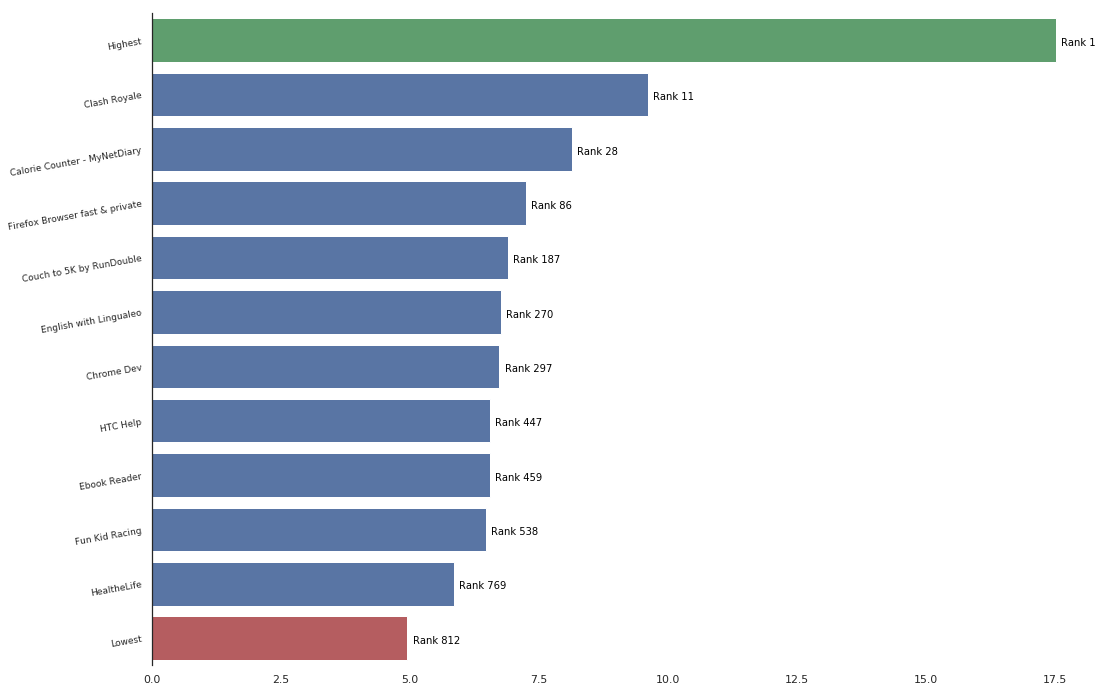

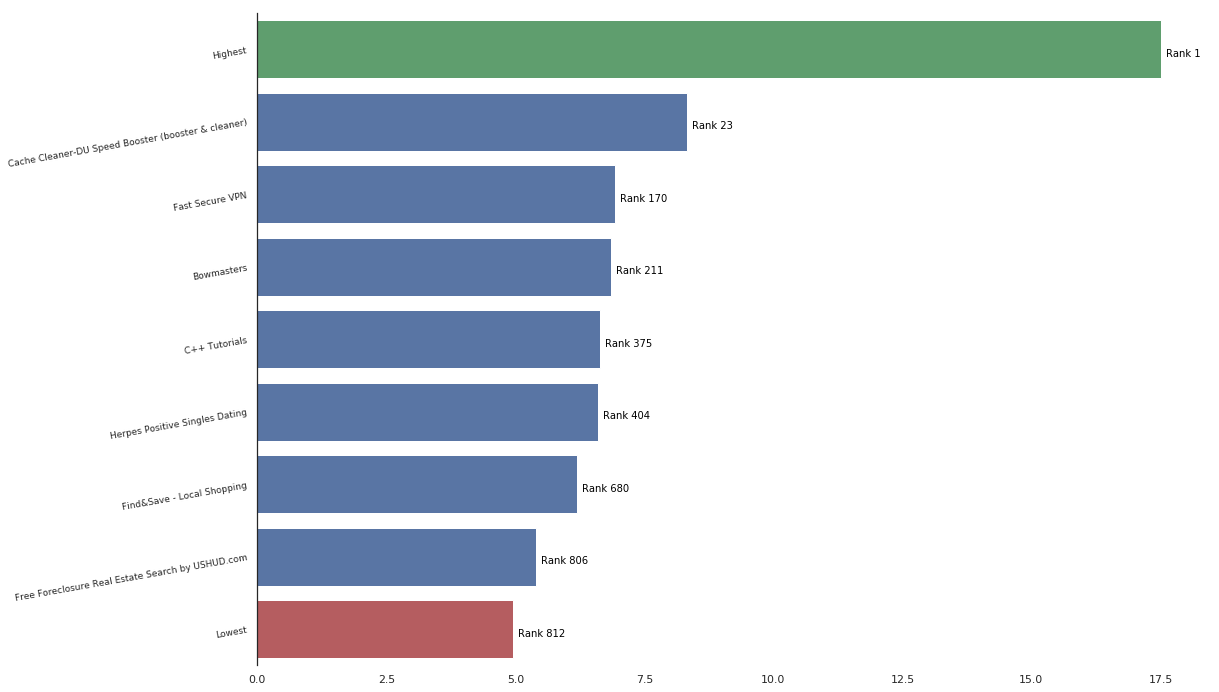

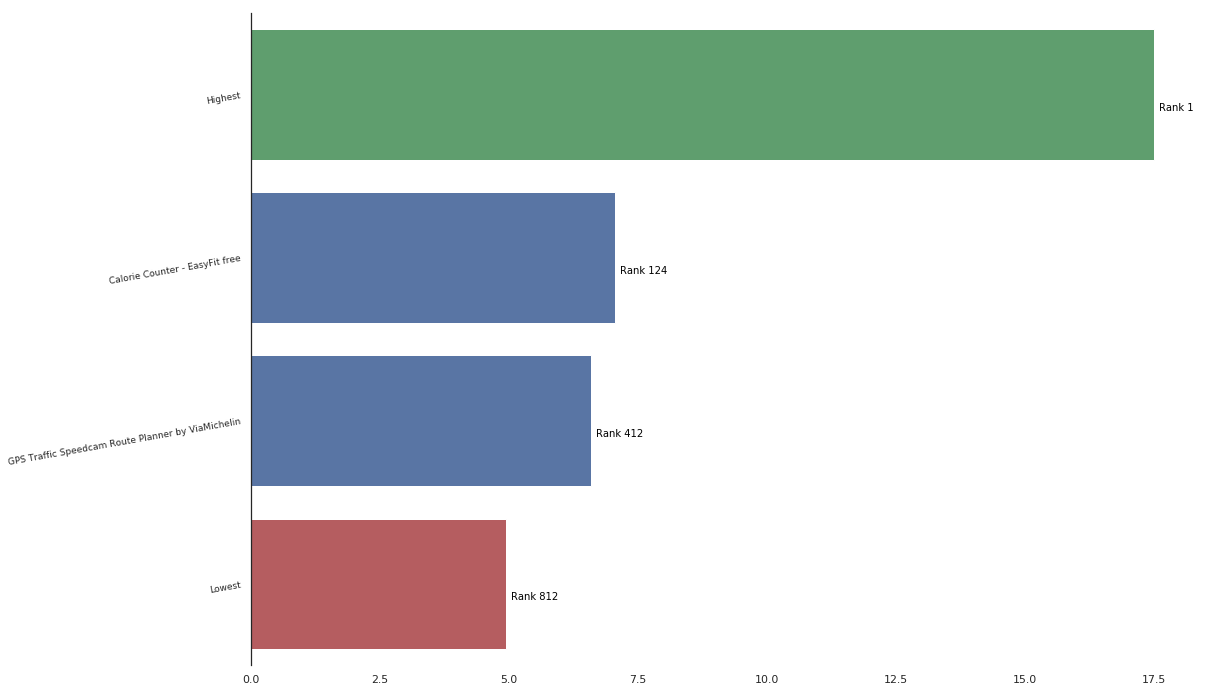

In [23]:
# Generating data for dummy developers
d11 = dev_dash(dev1)
d21 = dev_dash(dev2)
d31 = dev_dash(dev3)

In [24]:
D1=pd.DataFrame(most_popular)
D1['percentage']=[(ratings/5)*100 for ratings in D1['Rating']]
D2=D1[['App','Rating','Installs','percentage']]
D2.reset_index(drop=True,inplace=True)
D3=pd.DataFrame(most_down)
D3['percentage']=[(ratings/5)*100 for ratings in D1['Rating']]
D3.reset_index(drop=True,inplace=True)
D4=D3[['App','Rating','Installs','percentage']]
D4
D5=pd.DataFrame(most_rated)
D5['percentage']=[(ratings/5)*100 for ratings in D1['Rating']]
D5.reset_index(drop=True,inplace=True)
D6=D5[['App','Rating','Installs','percentage']]
D6

,App,Rating,Installs,percentage
0,CDL Practice Test 2018 Edition,4.9,100000,82.0
1,Down Dog: Great Yoga Anywhere,4.9,500000,90.0
2,DMV Permit Practice Test 2018 Edition,4.9,100000,88.0
3,30 Day Fitness Challenge - Workout at Home,4.8,10000000,80.0
4,"Even - organize your money, get paid early",4.8,100000,86.0
5,Fuzzy Seasons: Animal Forest,4.8,100000,84.0
6,Calculator with Percent (Free),4.8,1000000,92.0
7,GoodRx Drug Prices and Coupons,4.8,1000000,88.0
8,Home Workout for Men - Bodybuilding,4.8,1000000,84.0
9,Find a Way: Addictive Puzzle,4.8,500000,78.0


In [ ]:
from werkzeug.wrappers import Request, Response
from flask import Flask,render_template, redirect , url_for,request


app = Flask(__name__,template_folder='template',static_folder='static')
app.debug=True


@app.route("/",methods=['GET', 'POST'])
def main():
    table=D2
    table1=D4
    table2=D6
    admin=['dev11@gmail','dev12@gmail','dev13@gmail','1111','2222','3333']
    error = None
    if request.method == 'POST':
        if request.form['username'] not in  admin or request.form['password'] not in  admin:
            error = 'Invalid Credentials. Please try again.'
            
        else:
            if request.form['username'] == 'dev11@gmail':
                return render_template('index1.html',dic=d11,dev=dev1)
                                
       
            elif request.form['username']== 'dev12@gmail':
                return render_template('index1.html',dic=d21,dev=dev2)
                                       
       
            elif request.form['username']== 'dev13@gmail':
                return render_template('index1.html',dic=d31,dev=dev3)
                                      
            else:
                return redirect('forgot')
    return render_template('index7.html',table=D2,table1=D4,table2=D6,error=error)
    

       
@app.route("/forgot")
def forgot():
     return render_template('index5.html')


if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)


